In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import math
import seaborn as sns;
sns.set()

In [64]:
from abc import ABC, abstractmethod

class PairsTrading(ABC):
    
    def __init__(self,pair, weight = [1,1], formation_period = 504, trading_period = 252, outerbound = 0.45, innerbound = 0):
        #attributes
        self.pair = pair
        self.weight = weight
        self.formation_period = formation_period
        self.trading_period = trading_period
        self.outerbound = outerbound
        self.innerbound = innerbound
        
        #stored output
        self.model = None
        self.signal = None
        self.actions = None
        self.portfolio = None
        self.position_count = None
    
    @abstractmethod 
    def fit(self, data): 
        raise NotImplementedError("Must override")
    @abstractmethod 
    def generateSignal(self, data):
        raise NotImplementedError("Must override")
    @abstractmethod 
    def generateActions(self, signal, outerbound, innerbound):
        raise NotImplementedError("Must override")
    
    def trade(self,logreturns):
        # assumptions
        capital = 100
        #reinv_ratio = 0
        w = [self.weight[0],self.weight[1]]
        actions = self.actions

        portfolio = pd.DataFrame(columns = self.pair,index=actions.index)

        # day 0 balance
        portfolio['Cash'] = 0
        portfolio.iloc[:,:2] = 0
        #reinvest = 0

        for i in range(actions.shape[0]):
            if i != 0:
                portfolio.iloc[i,2] = portfolio.iloc[i-1,2]

            if portfolio.iloc[i-1,0] == 0:
                # if no stocks in portfolio 
                portfolio.iloc[i,0] = actions.iloc[i,0]*w[0]*capital
                portfolio.iloc[i,1] = actions.iloc[i,1]*w[1]*capital
                portfolio.iloc[i,2] = portfolio.iloc[i,2] - portfolio.iloc[i,0] - portfolio.iloc[i,1]
            else:
                # if have positions 
                # calculate day-end
                portfolio.iloc[i,0] = portfolio.iloc[i-1,0]+(np.exp(logreturns.loc[portfolio.index[i],self.pair[0]]/100)-1)*portfolio.iloc[i-1,0]
                portfolio.iloc[i,1] = portfolio.iloc[i-1,1]+(np.exp(logreturns.loc[portfolio.index[i],self.pair[1]]/100)-1)*portfolio.iloc[i-1,1]

                # if not hold
                if actions.iloc[i,0] != 0:
                    act0 = actions.iloc[i,0]*abs(portfolio.iloc[i,0])
                    act1 = actions.iloc[i,1]*abs(portfolio.iloc[i,1])
                    portfolio.iloc[i,2] = portfolio.iloc[i,2]-act0-act1
                    portfolio.iloc[i,0] = portfolio.iloc[i,0]+act0
                    portfolio.iloc[i,1] = portfolio.iloc[i,1]+act1
                    #reinvest = np.max([reinv_ratio*(-act0-act1),0])


        print('weight of '+logreturns.columns[0]+': '+ str(w[0]))
        print('weight of '+logreturns.columns[1]+': '+ str(w[1]))
        print('long spread position:')
        print(logreturns.columns[0]+': '+str(w[0]*capital))
        print(logreturns.columns[1]+': '+str(-w[1]*capital))
        print('long spread value:')
        print(capital*w[0]-capital*w[1])

        portfolio['PnL'] = pd.DataFrame(portfolio.sum(axis=1))
        portfolio['Daily PnL'] = portfolio['PnL'] - portfolio['PnL'].shift(1)
        portfolio['std'] = portfolio['Daily PnL'].rolling(252).std()
        portfolio['mean'] = portfolio['Daily PnL'].rolling(252).mean()
        # IR = Information Ratio = Avg(PnL)/Std_dev(PnL) over 252 days
        portfolio['IR'] = portfolio['mean']/portfolio['std']
        # Sharpe = annualized IR = IR*sqrt(252)
        portfolio['Rolling Sharpe'] = portfolio['IR']*math.sqrt(252)
        portfolio = portfolio.drop(['mean'],axis=1)
        try:
            totalSharpe = math.sqrt(252)*portfolio['Daily PnL'].mean()/portfolio['Daily PnL'].std()
        except:
            totalSharpe = 0
            
        plt.plot(portfolio['PnL'])
        plt.ylabel('Cumulative Profit and Loss (USD)')
        plt.figtext(0.1,0.9,'Sharpe Ratio: '+ '{:.2f}'.format(totalSharpe) + '   Position Count: {}'.format(self.position_count))
        plt.show()

        plt.plot(portfolio['Rolling Sharpe'].dropna())
        plt.ylabel('252-day Rolling Sharpe')
        plt.figtext(0.1,0.9,'Sharpe Ratio: '+ '{:.2f}'.format(totalSharpe) + '   Position Count: {}'.format(self.position_count))
        plt.show()
        
        self.portfolio = portfolio
        return portfolio
    
    def quickRun(self, inputdata, logreturns, rolling = False): 
        if rolling==True:
            n = (inputdata.shape[0] - self.formation_period) // self.trading_period
            unuse = (inputdata.shape[0] - self.formation_period) % self.trading_period
            inputdata = inputdata.iloc[unuse:,:]
            signal = pd.DataFrame()
            actions = pd.DataFrame()
            position_count_all = 0
            
            for i in range(n):
                train = inputdata.iloc[i*self.trading_period : i*self.trading_period + self.formation_period,:]
                test = inputdata.iloc[i*self.trading_period + self.formation_period : i*self.trading_period + self.formation_period + self.trading_period,:]
                print('train:')
                print(train.index)
                print('test:')
                print(test.index)
                self.fit(train)
                self.generateSignal(test)
                self.generateActions()
                signal = pd.concat([signal,self.signal],axis=0)
                actions = pd.concat([actions,self.actions],axis=0)
                position_count_all += self.position_count
            
            self.signal = signal
            self.actions = actions
            self.position_count = position_count_all
            self.trade(logreturns)
                
        else:
            train = inputdata.iloc[:self.formation_period,:]
            self.fit(train)
            self.generateSignal(inputdata)
            self.generateActions()
            self.trade(logreturns)
        

In [65]:
import math
import scipy.integrate

from scipy.special  import comb, erfinv, gamma
from scipy.stats    import norm, t
from scipy.optimize import root
from scipy.optimize import newton
from scipy.optimize import minimize
from scipy.stats import norm

import numpy.random as npr
import scipy.stats as scs

from distutils.log import error
from statsmodels.distributions.empirical_distribution import ECDF

import warnings
# suppress warnings
warnings.filterwarnings('ignore')

from statsmodels.distributions.copula.api import FrankCopula,CopulaDistribution, GumbelCopula, IndependenceCopula, ClaytonCopula, GaussianCopula, StudentTCopula


class Copula(PairsTrading):
    def __init__(self,pair,quantileinput = False, assumedcdf = 'ECDF', resetflag = True, weight = [1,1], formation_period = 504, trading_period = 252, outerbound = 0.45, innerbound = 0):
        super().__init__(pair, weight, formation_period, trading_period, outerbound, innerbound)
        self.quantileinput = quantileinput
        self.cdf = None
        self.type = None
        self.assumedcdf = assumedcdf
        self.resetflag = resetflag
        
    def getAttributes(self):
        attributes_ = {'pair': self.pair,
                        'type': self.type,
                        'weight': self.weight,
                        'formation_period':self.formation_period,
                        'trading_period': self.trading_period,
                        'outerbound': self.outerbound,
                        'innerbound': self.innerbound,
                        'quantileinput': self.quantileinput,
                        'cdf': self.cdf, #fitted cdf
                        'assumedcdf': self.assumedcdf,
                        'resetflag': self.resetflag
                         }
        return attributes_
    def Cvgu(self,u,v):
        theta = self.model.theta
        if self.type == FrankCopula:
            def _g(z):
                return np.exp(-theta * z) - 1
            #num = _g(u) * _g(v) + _g(u)
            #den = _g(u) * _g(v) + _g(1)
            #return (num / den)[0]
            return self.model.cdfcond_2g1([u,v])[0]
            #C = u**(-theta-1)*(u**-theta + v**-theta - 1)**(-1/theta-1)
            #return C[0]
        elif self.type == ClaytonCopula:
            #A = np.power(v, -theta - 1)
            #B = np.power(v, -theta) + np.power(u, -theta) - 1
            #h = np.power(B, (-1 - theta) / theta)
            C = u**(-theta-1)*(u**-theta + v**-theta - 1)**(-1/theta-1)
            return C[0]
        elif self.type == GumbelCopula:
            a = np.power(u * v, -1)
            tmp = np.power(-np.log(u), theta) + np.power(-np.log(v), theta)
            b = np.power(tmp, 1 / theta - 1)
            c = np.power(-np.log(u), 1 - theta)*theta
            h = np.power(-np.log(u), theta) + np.power(-np.log(v), theta)
            h = -np.power(h, 1.0 / theta)
            cdfs = np.exp(h)
            return 1/((cdfs * b/c)[0])
        elif self.type == GaussianCopula:
            pass
        else:   
            print('Undefined Copula')
    
    def Cvgu_mixed(self,u,v,copula_list,params):
        dim = len(copula_list)
        F = 0
        for i in range(dim):
            self.type = copula_list[i]
            self.theta = params[dim+i]
            F += params[i] * Cvgu(self,u,v)
        return F
    
    def fit(self, data):
        CopulaType = FrankCopula
        copula = CopulaType()
        data_T = data.T.values
        
        def gaussian_pdf(u, v, rho):
            a = np.sqrt(2) * erfinv(2 * u - 1)
            b = np.sqrt(2) * erfinv(2 * v - 1)
            det_rho = 1 - rho**2

            return det_rho**-0.5 * np.exp(-((a**2 + b**2) * rho**2 -2 * a * b * rho) / (2 * det_rho))

        def studentT_pdf(u, v, param):
            rho = param[0]
            nu = param[1]

            term1 = gamma((nu + 2) / 2) * gamma(nu / 2) 
            term2 = gamma((nu + 1) / 2) ** 2

            u_ = t.ppf(u, df=nu)
            v_ = t.ppf(v, df=nu)

            det_rho = 1-rho**2
            multid = (-2 * u_ * v_ * rho + (u_ ** 2) + (v_ ** 2) ) / det_rho
            term3 = (1 + multid / nu) ** ((nu + 2) / 2)

            prod1 = (1 + (u_ ** 2) / nu) ** ((nu + 1) / 2) 
            prod2 = (1 + (v_ ** 2) / nu) ** ((nu + 1) / 2)
            prod = prod1 * prod2

            return (1/np.sqrt(det_rho)) * (term1 * prod) / (term2 * term3)

        def cmle(copula, data, opti_method='SLSQP'):
            n = len(data[0])
            # Transform the dataset to uniform margins
            ecdf1 = ECDF(data[0])
            ecdf2 = ECDF(data[1])
            if self.quantileinput == False:
                pseudo_sample = np.array(
                    [[n * l / (n + 1) for l in ecdf1(data[0])], [n * l / (n + 1) for l in ecdf2(data[1])]])
            else:
                pseudo_sample = np.array(
                    [[n * l / (n + 1) for l in data[0]], [n * l / (n + 1) for l in data[1]]])
            
            # calculate the log likelihood
            def log_likelihood(parameter):
                if isinstance(copula, GaussianCopula):
                    logl = -np.sum(np.log(gaussian_pdf(pseudo_sample[0], pseudo_sample[1], parameter)))
                elif isinstance(copula, StudentTCopula):
                    logl = -np.sum(np.log(studentT_pdf(pseudo_sample[0], pseudo_sample[1], parameter)))
                else:
                    logl = -np.sum(np.log(copula.pdf(pseudo_sample.T, parameter)))
                return logl

            # fitting
            if isinstance(copula, ClaytonCopula):
                initial_param = 0.5
                bounds_param = [(1e-6, None)]
            elif isinstance(copula, FrankCopula):
                initial_param = 2
                bounds_param = [(None, None)]
            elif isinstance(copula, GumbelCopula):
                initial_param = 1.5
                bounds_param = [(1, None)]
            elif isinstance(copula, GaussianCopula):
                initial_param = 0
                bounds_param = [(-1, 1)]
            elif isinstance(copula, StudentTCopula):
                initial_param = [0, 1]
                bounds_param = [(-1+1e-6, 1-1e-6), (1e-6, None)]
                opti_method = 'Nelder-Mead'
            else:
                print("only available with Clayton, Frank, Gumbel, Gaussian and StudentT")

            results = minimize(log_likelihood, initial_param, method=opti_method, bounds=bounds_param, options={})
            if results.success == True:
                    return (results.x, -results.fun), [ecdf1,ecdf2]
            else:
                print("fitting failed")
                return None
        
        def pdf_mixed(copula, u, v, params):
            dim = len(copula) # number of components in mixed copula
            pdf = 0
            for i in range(dim):
                if isinstance(copula[i], GaussianCopula):
                    pdf += params[i] * gaussian_pdf(u, v, params[dim+i])
                else:
                    pdf += params[i] * (copula[i].pdf((u,v), params[dim+i]))

            return pdf
        
        def cmle_mixed(copula, data, opti_method='SLSQP'):
            dim = len(copula)  # number of copula components
            n = len(data[0])

            # Transform the dataset to uniform margins
            ecdf1 = ECDF(data[0])
            ecdf2 = ECDF(data[1])

            if self.quantileinput == False:
                pseudo_sample = np.array(
                    [[n * l / (n + 1) for l in ecdf1(data[0])], [n * l / (n + 1) for l in ecdf2(data[1])]])
            else:
                pseudo_sample = np.array(
                    [[n * l / (n + 1) for l in data[0]], [n * l / (n + 1) for l in data[1]]])

            # calculate the log likelihood
            def log_likelihood(parameters):
                logl = -sum([ np.log(pdf_mixed(copula_mixed, pseudo_sample[0][i],pseudo_sample[1][i], parameters)) for i in range(0,len(pseudo_sample[0]))])
                return logl

            def con(parameters):
                return 1-sum(parameters[:dim])

            # fitting
            bounds_param = [(0,1) for _ in range(dim)]
            initial_param = [np.array(1.0/dim) for _ in range(dim)]

            for i in range(dim):
                if isinstance(copula[i], ClaytonCopula):
                    initial_param.append(0.5)
                    bounds_param.append((1e-6, None))
                elif isinstance(copula[i], FrankCopula):
                    initial_param.append(2)
                    bounds_param.append((None, None))
                elif isinstance(copula[i], GumbelCopula):
                    initial_param.append(1.5)
                    bounds_param.append((1, None))
                elif isinstance(copula[i], GaussianCopula):
                    initial_param.append(0)
                    bounds_param.append((-1, 1))
                else:
                    print("only available with Clayton, Frank, Gumbel, Gaussian")

            cons = {'type':'eq', 'fun':con}

            results = minimize(log_likelihood, initial_param, method=opti_method, bounds=bounds_param, constraints=cons, options={})

            if results.success == True:
                for i in range(dim):
                    if results.x[i] < 0.1:
                        print(results.x, - results.fun)
                        print(str(copula_mixed[i])[46:-26] + " omitted")
                        copula.pop(i)
                        return cmle_mixed(copula,data)
                return (results.x, -results.fun), [ecdf1,ecdf2]
            else:
                print(results)
                print("fitting failed")
                return None
        """candidates = []
        for CopulaType in [ClaytonCopula, GumbelCopula, FrankCopula]:
            copula = CopulaType()
            result, cdf = cmle(copula,data_T)
            candidates.append((result, cdf))
        logl_cand = [r[1] for r,cdf in candidates]
        print(logl_cand)
        select_index = logl_cand.index(max(logl_cand))
        result, cdf = candidates[select_index] """
        result, cdf = cmle(copula, data_T)
        theta = result[0]
        maxlikelihood = result[1]
        h = sns.jointplot(x=data.iloc[:, 0], y=data.iloc[:, 1], kind="scatter")
        _ = h.set_axis_labels("X1", "X2", fontsize=16)
        plt.show()
        
        #CopulaType = [ClaytonCopula, GumbelCopula, FrankCopula][select_index]
        #print("selected Copula ",CopulaType)
        if CopulaType!=GaussianCopula and CopulaType!=StudentTCopula:
            self.model = CopulaType(theta=theta)
        else:
            self.model = CopulaType()
        self.type = CopulaType
        self.cdf = cdf
        return self.model, maxlikelihood
    
    def generateSignal(self, data):
        
        signal = pd.DataFrame(index=data.index,columns=data.columns)
        
        for i in data.index:
            if self.quantileinput == True:
                u = data.loc[i,self.pair[0]]
                v = data.loc[i,self.pair[1]]
            elif self.assumedcdf == 'ECDF':
                u = self.cdf[0](data.loc[i,self.pair[0]])
                v = self.cdf[1](data.loc[i,self.pair[1]])
            elif self.assumedcdf == 'normal01':
                u = norm.cdf(data.loc[i,self.pair[0]])
                v = norm.cdf(data.loc[i,self.pair[1]])
            else:
                # list of 2 cdf functions
                u = assumedcdf[0](data.loc[i,self.pair[0]])
                v = assumedcdf[1](data.loc[i,self.pair[1]])
                
            signal.loc[i,self.pair[0]] = self.Cvgu(v,u)
            signal.loc[i,self.pair[1]] = self.Cvgu(u,v) 
            self.signal = signal
            
        return signal
    
    def generateActions(self):
        actions = []
        position = 0
        MI = self.signal - 0.5
        flagU = 0
        flagV = 0
        tracker = []
        position_count = 0
        
        for i in range(MI.shape[0]):
            flagU = flagU + MI.iloc[i,0]
            flagV = flagV + MI.iloc[i,1]
            tracker.append([flagU,flagV])
            
            if position == 0:
                # check for entry signal
                if flagU > self.outerbound and flagV < - self.outerbound:
                    actions.append([-1, 1])
                    position = -1
                    position_count += 1
                elif flagU < - self.outerbound and flagV > self.outerbound:
                    actions.append([1, -1])
                    position = 1
                    position_count += 1
                else:
                    actions.append([0, 0])

            else:
                # check for exit signal
                if position == -1:
                    if flagU < self.innerbound or flagV > - self.innerbound:
                        actions.append([1, -1])
                        position = 0
                        if(self.resetflag):
                            flagU = 0
                            flagV = 0
                    else:
                        actions.append([0, 0])
                else:
                    if flagU > - self.innerbound or flagV < self.innerbound:
                        actions.append([-1, 1])
                        position = 0
                        if(self.resetflag):
                            flagU = 0
                            flagV = 0
                    else:
                        actions.append([0, 0])
            
            
        actions = pd.DataFrame(actions, index=MI.index, columns=pair)
        self.actions = actions
        
        self.position_count = position_count
        return actions, tracker

In [66]:
import math
import warnings
# suppress warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

class Cointegration(PairsTrading):
    def __init__(self,pair, threshold_option = 'rolling', formation_period = 504, trading_period = 252, outerbound = 0.4, innerbound = 0):
        super().__init__(pair, [1,1], formation_period, trading_period, outerbound, innerbound)
        self.threshold_option = threshold_option
        
    def getAttributes(self):
        attributes_ = {'pair': self.pair,
                        'weight': self.weight,
                        'formation_period':self.formation_period,
                        'trading_period': self.trading_period,
                        'outerbound': self.outerbound,
                        'innerbound': self.innerbound,
                        'threshold_option': self.threshold_option
                         }
        return attributes_
        
    def fit(self, data):
        """
        Regression between x and y.
        y = beta @ x + intercept
        :param x: explanatory variable, shape: (N, 1)
        :param y: response variable, shape: (N, 1)
        :return: 1. spread/residual, y - beta @ x
                 2. beta
        """
        y = data.iloc[:,0].values
        x = data.iloc[:,1].values.reshape(-1, 1)
        model = LinearRegression()
        self.model = model.fit(x, y)
        beta = model.coef_[0]
        self.weight = [1,beta]
        return model

    def mean(self,spread):
            if self.threshold_option == 'rolling':
                mean = spread.rolling(self.formation_period).mean()
                mean.iloc[:self.formation_period,:] = spread.iloc[:self.formation_period,:].mean()
                return mean
            else:
                return spread.iloc[:self.formation_period,:].mean()
                
    def std(self,spread):
            if self.threshold_option == 'rolling':
                std = spread.rolling(self.formation_period).std()
                std.iloc[:self.formation_period,:] = spread.iloc[:self.formation_period,:].std()
                return std
            else:
                return spread.iloc[:self.formation_period,:].std()
    
    def generateSignal(self, data):
        beta = self.model.coef_[0]
        spread = pd.DataFrame(data.iloc[:,0] - beta*data.iloc[:,1],columns = ['Spread'])
        mean = self.mean(spread)
        std = self.std(spread)
        signal = (spread - mean)/std
        self.signal = signal
        return signal
    
    def generateActions(self):
        actions = []
        position = 0
        signal = self.signal
        self.position_count = 0
        
        upper_ci = norm.ppf(0.5 + self.outerbound)
        lower_ci = norm.ppf(0.5 - self.outerbound)
        upper_ci_inner = norm.ppf(0.5 + self.innerbound)
        lower_ci_inner = norm.ppf(0.5 - self.innerbound)
        
        for i in range(signal.shape[0]):
        
            if position == 0:
                if signal.iloc[i,0] > upper_ci:
                    actions.append([-1, 1])
                    position = -1
                    self.position_count += 1
                elif signal.iloc[i,0] < lower_ci:
                    actions.append([1, -1])
                    position = 1
                    self.position_count += 1
                else:
                    actions.append([0, 0])

            else:
                if position == -1:
                    if signal.iloc[i,0] < upper_ci_inner:
                        actions.append([1, -1])
                        position = 0
                    else:
                        actions.append([0, 0])
                else:
                    if signal.iloc[i,0] > lower_ci_inner:
                        actions.append([-1, 1])
                        position = 0
                    else:
                        actions.append([0, 0])
            
        actions = pd.DataFrame(actions, index=signal.index, columns=self.pair)
        self.actions = actions
        return actions

In [67]:
from arch import arch_model
from arch.__future__ import reindexing

def GARCHfilter(data, window=75, plot=True):
    rollingvol = pd.DataFrame()
    std_residual = pd.DataFrame()
    mean = pd.DataFrame()

    for j in range(data.shape[1]):

        am = arch_model(data.iloc[:,j], vol="garch", p=1,o=0,q=1,rescale=True,mean='Constant')

        # rolling window forecast
        start_loc = 0
        end_loc = window # default: 1-quarter window
        test_size = data.shape[0] - end_loc
        mu = []
        forecasts = {}
        std_res = {}

        for i in range(test_size):    
            #sys.stdout.write(".")
            #sys.stdout.flush()
            res = am.fit(first_obs=i, last_obs=i + end_loc, disp="off")
            temp = res.forecast(horizon=1, reindex=False).variance
            fcast = temp.iloc[0]
            forecasts[fcast.name] = np.sqrt(fcast)
            mu.append(res.params["mu"])
            std_res[fcast.name] = (data.loc[fcast.name,data.columns[j]] - res.params["mu"])/np.sqrt(fcast)
        print()
        rollingvol[data.columns[j]]=pd.DataFrame(forecasts).transpose()
        mean[data.columns[j]] = pd.DataFrame(mu,index = rollingvol.index)
        std_residual[data.columns[j]] = pd.DataFrame(std_res).transpose()

    #plot results
    if plot == True:
        plt.plot(rollingvol)
        plt.ylabel('Volatility (Rolling Window Forecast)')
        plt.legend(rollingvol.columns)
        plt.show()

        plt.plot(data.loc[rollingvol.index,:])
        plt.ylabel('logreturns')
        plt.legend(data.columns)
        plt.show()

        plt.plot(mean)
        plt.ylabel('Mean (Rolling Window Forecast)')
        plt.legend(mean.columns)
        plt.show()

        plt.plot(std_residual)
        plt.ylabel('Standardized Residuals from GARCH')
        plt.legend(std_residual.columns)
        plt.show()

    return std_residual
    

In [68]:
def LoadData(tickerlist, period='5y'):
    data = yf.download(  # or pdr.get_data_yahoo(...
            # tickers list or string as well
            tickers = tickerlist,

            # use "period" instead of start/end
            # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
            # (optional, default is '1mo')
            period = period,

            # fetch data by interval (including intraday if period < 60 days)
            # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
            # (optional, default is '1d')
            interval = "1d",

            # Whether to ignore timezone when aligning ticker data from 
            # different timezones. Default is False.
            ignore_tz = False, # !!

            # group by ticker (to access via data['SPY'])
            # (optional, default is 'column')
            group_by = 'ticker',

            # adjust all OHLC automatically
            # (optional, default is False)
            auto_adjust = False,  

            # attempt repair of missing data or currency mixups e.g. $/cents
            repair = False,

            # download pre/post regular market hours data
            # (optional, default is False)
            prepost = False,

            # use threads for mass downloading? (True/False/Integer)
            # (optional, default is True)
            threads = True,

            # proxy URL scheme use use when downloading?
            # (optional, default is None)
            proxy = None
        )
    
    collist = []
    
    for i in data.columns:
        if i[1] == 'Close': #there were no adj close for most tickers
            collist.append(i)
    data = data[collist]
    
    tmp = []
    for i in data.columns:
        tmp.append(i[0])
    data.columns = tmp
    
    return data

In [69]:
def CleanData(data): #for cleaning data of 1 pair
    
    # 1) separate the data
    df1 = data.iloc[:,0].copy(deep=True)
    df1.index = df1.index.values.astype('M8[D]')
    df1 = pd.DataFrame(df1.dropna())
    df2 = data.iloc[:,1].copy(deep=True)
    df2.index = df2.index.values.astype('M8[D]')
    df2 = pd.DataFrame(df2.dropna())
    
    # 2) cal logreturn
    df1 = 100*np.log(df1/df1.shift(1))
    df2 = 100*np.log(df2/df2.shift(1))
    
    # 3) join
    data = df1.join(df2,how='left',lsuffix=1)
    
    # 4) dropna
    data.dropna(inplace=True)
    return data

In [70]:
def CleanPriceData(data): # for cleaning price data of 1 pair
    df1 = data.iloc[:,0].copy(deep=True)
    df1.index = df1.index.values.astype('M8[D]')
    df1 = pd.DataFrame(df1.dropna())
    df2 = data.iloc[:,1].copy(deep=True)
    df2.index = df2.index.values.astype('M8[D]')
    df2 = pd.DataFrame(df2.dropna())
    data = df1.join(df2,how='left')
    data.dropna(inplace=True)
    return data

[*********************100%***********************]  2 of 2 completed




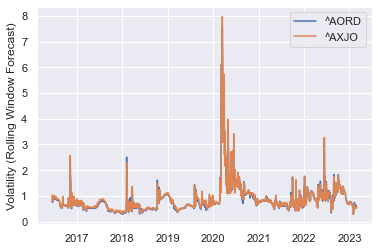

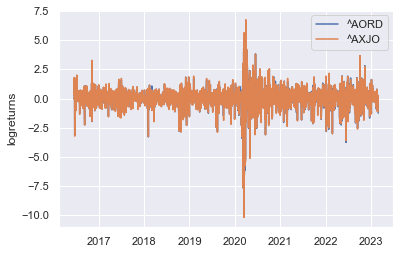

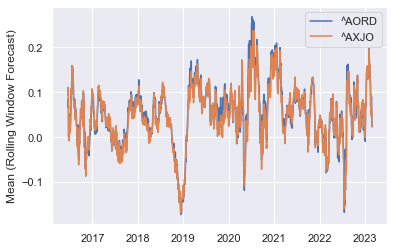

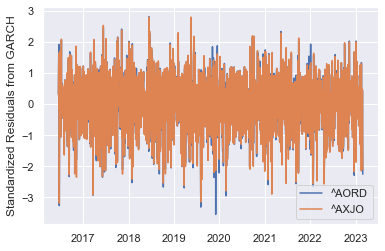

train:
DatetimeIndex(['2017-03-02', '2017-03-05', '2017-03-06', '2017-03-07',
               '2017-03-08', '2017-03-09', '2017-03-12', '2017-03-13',
               '2017-03-14', '2017-03-15',
               ...
               '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21',
               '2019-02-24', '2019-02-25', '2019-02-26', '2019-02-27',
               '2019-02-28', '2019-03-03'],
              dtype='datetime64[ns]', length=504, freq=None)
test:
DatetimeIndex(['2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07',
               '2019-03-10', '2019-03-11', '2019-03-12', '2019-03-13',
               '2019-03-14', '2019-03-17',
               ...
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-23',
               '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27',
               '2020-03-01', '2020-03-02'],
              dtype='datetime64[ns]', length=252, freq=None)


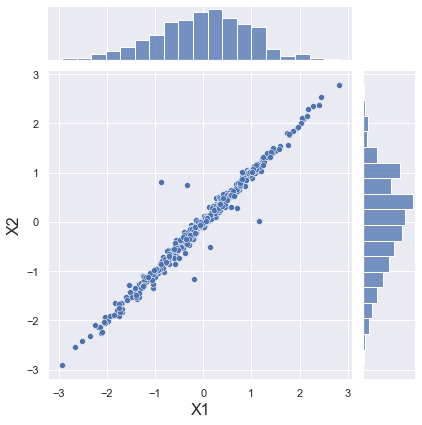

train:
DatetimeIndex(['2018-03-04', '2018-03-05', '2018-03-06', '2018-03-07',
               '2018-03-08', '2018-03-11', '2018-03-12', '2018-03-13',
               '2018-03-14', '2018-03-15',
               ...
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-23',
               '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27',
               '2020-03-01', '2020-03-02'],
              dtype='datetime64[ns]', length=504, freq=None)
test:
DatetimeIndex(['2020-03-03', '2020-03-04', '2020-03-05', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-15', '2020-03-16',
               ...
               '2021-02-15', '2021-02-16', '2021-02-17', '2021-02-18',
               '2021-02-21', '2021-02-22', '2021-02-23', '2021-02-24',
               '2021-02-25', '2021-02-28'],
              dtype='datetime64[ns]', length=252, freq=None)


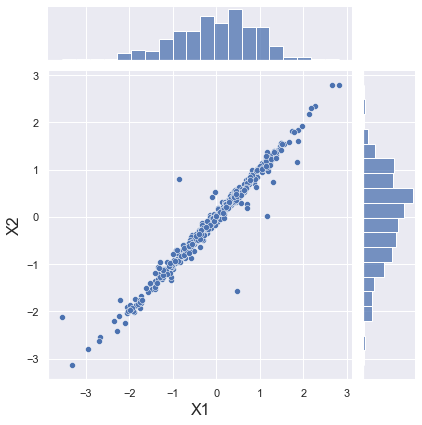

train:
DatetimeIndex(['2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07',
               '2019-03-10', '2019-03-11', '2019-03-12', '2019-03-13',
               '2019-03-14', '2019-03-17',
               ...
               '2021-02-15', '2021-02-16', '2021-02-17', '2021-02-18',
               '2021-02-21', '2021-02-22', '2021-02-23', '2021-02-24',
               '2021-02-25', '2021-02-28'],
              dtype='datetime64[ns]', length=504, freq=None)
test:
DatetimeIndex(['2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04',
               '2021-03-07', '2021-03-08', '2021-03-09', '2021-03-10',
               '2021-03-11', '2021-03-14',
               ...
               '2022-02-13', '2022-02-14', '2022-02-15', '2022-02-16',
               '2022-02-17', '2022-02-20', '2022-02-21', '2022-02-22',
               '2022-02-23', '2022-02-24'],
              dtype='datetime64[ns]', length=252, freq=None)


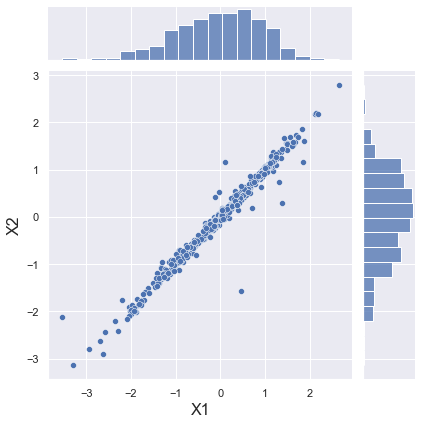

train:
DatetimeIndex(['2020-03-03', '2020-03-04', '2020-03-05', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-15', '2020-03-16',
               ...
               '2022-02-13', '2022-02-14', '2022-02-15', '2022-02-16',
               '2022-02-17', '2022-02-20', '2022-02-21', '2022-02-22',
               '2022-02-23', '2022-02-24'],
              dtype='datetime64[ns]', length=504, freq=None)
test:
DatetimeIndex(['2022-02-27', '2022-02-28', '2022-03-01', '2022-03-02',
               '2022-03-03', '2022-03-06', '2022-03-07', '2022-03-08',
               '2022-03-09', '2022-03-10',
               ...
               '2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16',
               '2023-02-19', '2023-02-20', '2023-02-21', '2023-02-22',
               '2023-02-23', '2023-02-26'],
              dtype='datetime64[ns]', length=252, freq=None)


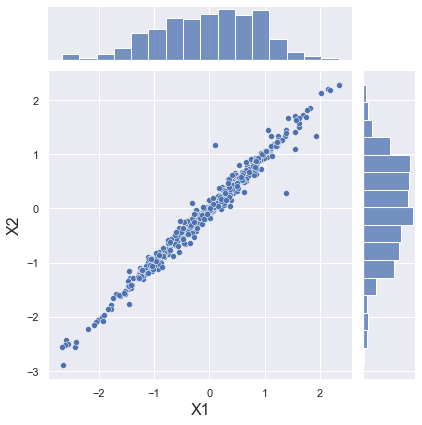

weight of ^AORD: 1
weight of ^AXJO: 1
long spread position:
^AORD: 100
^AXJO: -100
long spread value:
0


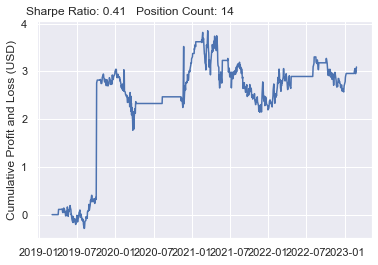

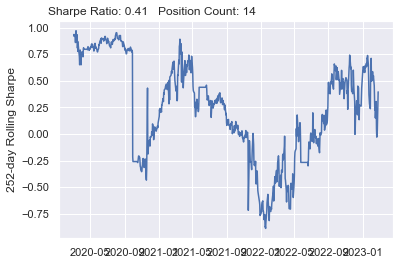

train:
DatetimeIndex(['2017-03-02', '2017-03-05', '2017-03-06', '2017-03-07',
               '2017-03-08', '2017-03-09', '2017-03-12', '2017-03-13',
               '2017-03-14', '2017-03-15',
               ...
               '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21',
               '2019-02-24', '2019-02-25', '2019-02-26', '2019-02-27',
               '2019-02-28', '2019-03-03'],
              dtype='datetime64[ns]', length=504, freq=None)
test:
DatetimeIndex(['2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07',
               '2019-03-10', '2019-03-11', '2019-03-12', '2019-03-13',
               '2019-03-14', '2019-03-17',
               ...
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-23',
               '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27',
               '2020-03-01', '2020-03-02'],
              dtype='datetime64[ns]', length=252, freq=None)


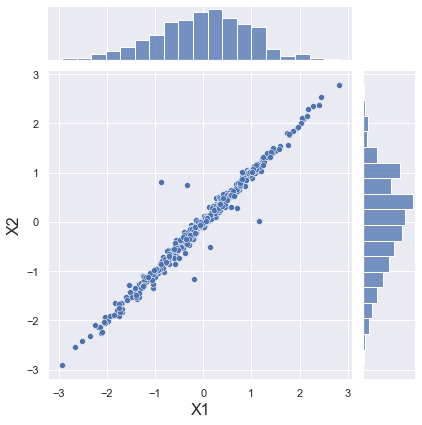

train:
DatetimeIndex(['2018-03-04', '2018-03-05', '2018-03-06', '2018-03-07',
               '2018-03-08', '2018-03-11', '2018-03-12', '2018-03-13',
               '2018-03-14', '2018-03-15',
               ...
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-23',
               '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27',
               '2020-03-01', '2020-03-02'],
              dtype='datetime64[ns]', length=504, freq=None)
test:
DatetimeIndex(['2020-03-03', '2020-03-04', '2020-03-05', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-15', '2020-03-16',
               ...
               '2021-02-15', '2021-02-16', '2021-02-17', '2021-02-18',
               '2021-02-21', '2021-02-22', '2021-02-23', '2021-02-24',
               '2021-02-25', '2021-02-28'],
              dtype='datetime64[ns]', length=252, freq=None)


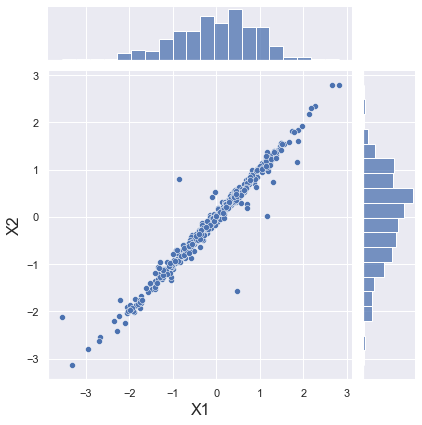

train:
DatetimeIndex(['2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07',
               '2019-03-10', '2019-03-11', '2019-03-12', '2019-03-13',
               '2019-03-14', '2019-03-17',
               ...
               '2021-02-15', '2021-02-16', '2021-02-17', '2021-02-18',
               '2021-02-21', '2021-02-22', '2021-02-23', '2021-02-24',
               '2021-02-25', '2021-02-28'],
              dtype='datetime64[ns]', length=504, freq=None)
test:
DatetimeIndex(['2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04',
               '2021-03-07', '2021-03-08', '2021-03-09', '2021-03-10',
               '2021-03-11', '2021-03-14',
               ...
               '2022-02-13', '2022-02-14', '2022-02-15', '2022-02-16',
               '2022-02-17', '2022-02-20', '2022-02-21', '2022-02-22',
               '2022-02-23', '2022-02-24'],
              dtype='datetime64[ns]', length=252, freq=None)


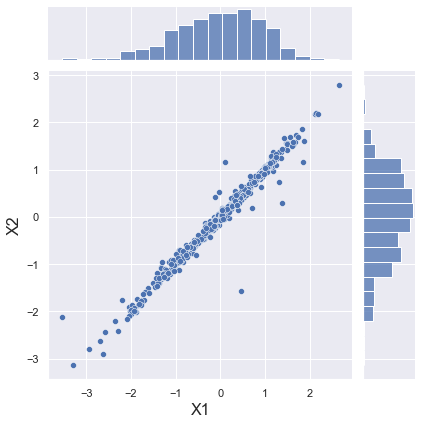

train:
DatetimeIndex(['2020-03-03', '2020-03-04', '2020-03-05', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-15', '2020-03-16',
               ...
               '2022-02-13', '2022-02-14', '2022-02-15', '2022-02-16',
               '2022-02-17', '2022-02-20', '2022-02-21', '2022-02-22',
               '2022-02-23', '2022-02-24'],
              dtype='datetime64[ns]', length=504, freq=None)
test:
DatetimeIndex(['2022-02-27', '2022-02-28', '2022-03-01', '2022-03-02',
               '2022-03-03', '2022-03-06', '2022-03-07', '2022-03-08',
               '2022-03-09', '2022-03-10',
               ...
               '2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16',
               '2023-02-19', '2023-02-20', '2023-02-21', '2023-02-22',
               '2023-02-23', '2023-02-26'],
              dtype='datetime64[ns]', length=252, freq=None)


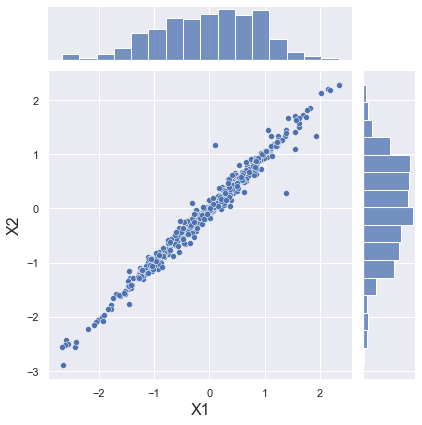

weight of ^AORD: 1
weight of ^AXJO: 1
long spread position:
^AORD: 100
^AXJO: -100
long spread value:
0


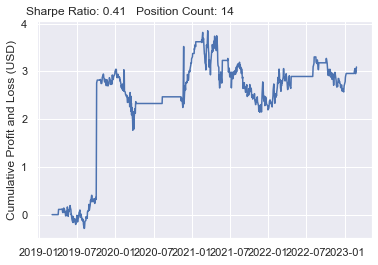

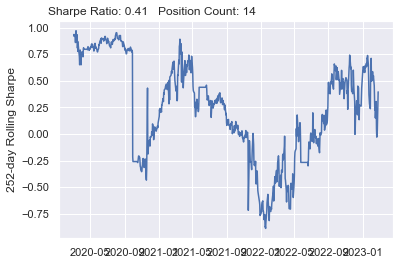

train:
DatetimeIndex(['2017-03-05', '2017-03-06', '2017-03-07', '2017-03-08',
               '2017-03-09', '2017-03-12', '2017-03-13', '2017-03-14',
               '2017-03-15', '2017-03-16',
               ...
               '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-24',
               '2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28',
               '2019-03-03', '2019-03-04'],
              dtype='datetime64[ns]', length=504, freq=None)
test:
DatetimeIndex(['2019-03-05', '2019-03-06', '2019-03-07', '2019-03-10',
               '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14',
               '2019-03-17', '2019-03-18',
               ...
               '2020-02-19', '2020-02-20', '2020-02-23', '2020-02-24',
               '2020-02-25', '2020-02-26', '2020-02-27', '2020-03-01',
               '2020-03-02', '2020-03-03'],
              dtype='datetime64[ns]', length=252, freq=None)


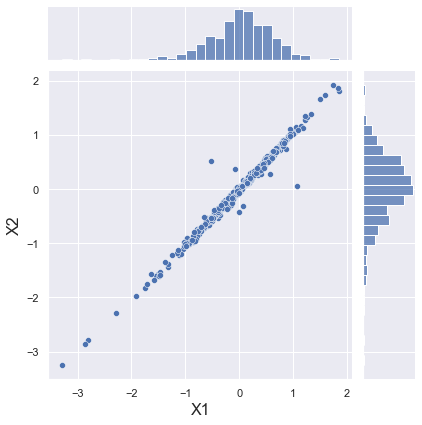

train:
DatetimeIndex(['2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08',
               '2018-03-11', '2018-03-12', '2018-03-13', '2018-03-14',
               '2018-03-15', '2018-03-18',
               ...
               '2020-02-19', '2020-02-20', '2020-02-23', '2020-02-24',
               '2020-02-25', '2020-02-26', '2020-02-27', '2020-03-01',
               '2020-03-02', '2020-03-03'],
              dtype='datetime64[ns]', length=504, freq=None)
test:
DatetimeIndex(['2020-03-04', '2020-03-05', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-15',
               '2020-03-16', '2020-03-17',
               ...
               '2021-02-16', '2021-02-17', '2021-02-18', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-28', '2021-03-01'],
              dtype='datetime64[ns]', length=252, freq=None)


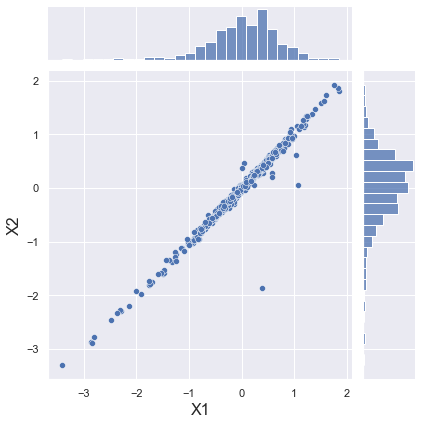

train:
DatetimeIndex(['2019-03-05', '2019-03-06', '2019-03-07', '2019-03-10',
               '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14',
               '2019-03-17', '2019-03-18',
               ...
               '2021-02-16', '2021-02-17', '2021-02-18', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-28', '2021-03-01'],
              dtype='datetime64[ns]', length=504, freq=None)
test:
DatetimeIndex(['2021-03-02', '2021-03-03', '2021-03-04', '2021-03-07',
               '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11',
               '2021-03-14', '2021-03-15',
               ...
               '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
               '2022-02-20', '2022-02-21', '2022-02-22', '2022-02-23',
               '2022-02-24', '2022-02-27'],
              dtype='datetime64[ns]', length=252, freq=None)


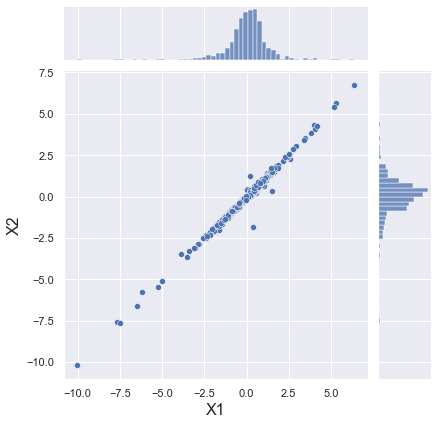

train:
DatetimeIndex(['2020-03-04', '2020-03-05', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-15',
               '2020-03-16', '2020-03-17',
               ...
               '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
               '2022-02-20', '2022-02-21', '2022-02-22', '2022-02-23',
               '2022-02-24', '2022-02-27'],
              dtype='datetime64[ns]', length=504, freq=None)
test:
DatetimeIndex(['2022-02-28', '2022-03-01', '2022-03-02', '2022-03-03',
               '2022-03-06', '2022-03-07', '2022-03-08', '2022-03-09',
               '2022-03-10', '2022-03-13',
               ...
               '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-19',
               '2023-02-20', '2023-02-21', '2023-02-22', '2023-02-23',
               '2023-02-26', '2023-02-27'],
              dtype='datetime64[ns]', length=252, freq=None)


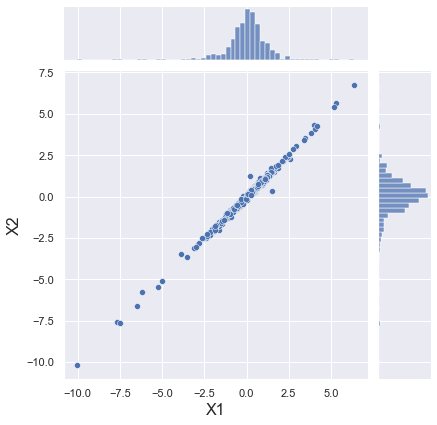

weight of ^AORD: 1
weight of ^AXJO: 1
long spread position:
^AORD: 100
^AXJO: -100
long spread value:
0


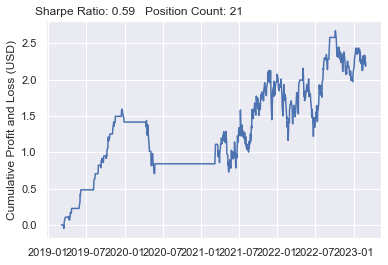

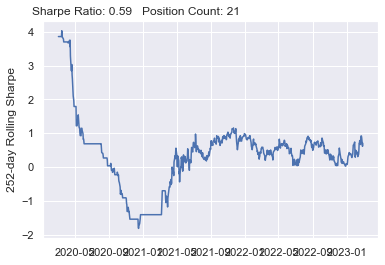

train:
DatetimeIndex(['2017-03-05', '2017-03-06', '2017-03-07', '2017-03-08',
               '2017-03-09', '2017-03-12', '2017-03-13', '2017-03-14',
               '2017-03-15', '2017-03-16',
               ...
               '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-24',
               '2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28',
               '2019-03-03', '2019-03-04'],
              dtype='datetime64[ns]', length=504, freq=None)
test:
DatetimeIndex(['2019-03-05', '2019-03-06', '2019-03-07', '2019-03-10',
               '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14',
               '2019-03-17', '2019-03-18',
               ...
               '2020-02-19', '2020-02-20', '2020-02-23', '2020-02-24',
               '2020-02-25', '2020-02-26', '2020-02-27', '2020-03-01',
               '2020-03-02', '2020-03-03'],
              dtype='datetime64[ns]', length=252, freq=None)


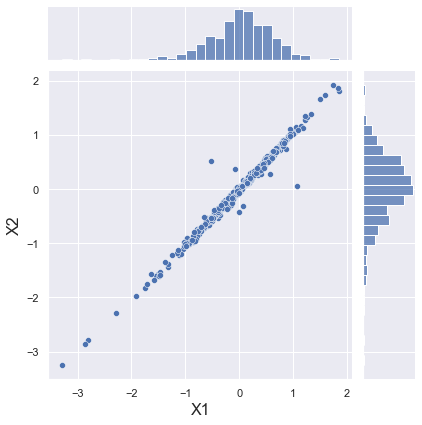

train:
DatetimeIndex(['2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08',
               '2018-03-11', '2018-03-12', '2018-03-13', '2018-03-14',
               '2018-03-15', '2018-03-18',
               ...
               '2020-02-19', '2020-02-20', '2020-02-23', '2020-02-24',
               '2020-02-25', '2020-02-26', '2020-02-27', '2020-03-01',
               '2020-03-02', '2020-03-03'],
              dtype='datetime64[ns]', length=504, freq=None)
test:
DatetimeIndex(['2020-03-04', '2020-03-05', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-15',
               '2020-03-16', '2020-03-17',
               ...
               '2021-02-16', '2021-02-17', '2021-02-18', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-28', '2021-03-01'],
              dtype='datetime64[ns]', length=252, freq=None)


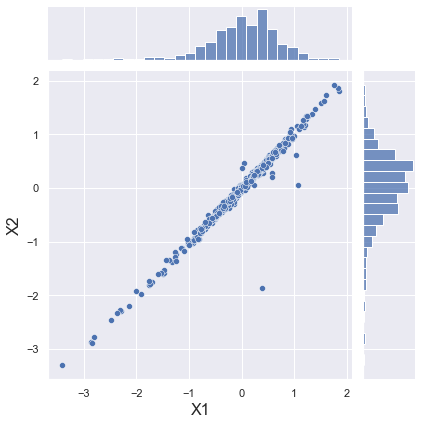

train:
DatetimeIndex(['2019-03-05', '2019-03-06', '2019-03-07', '2019-03-10',
               '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14',
               '2019-03-17', '2019-03-18',
               ...
               '2021-02-16', '2021-02-17', '2021-02-18', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-28', '2021-03-01'],
              dtype='datetime64[ns]', length=504, freq=None)
test:
DatetimeIndex(['2021-03-02', '2021-03-03', '2021-03-04', '2021-03-07',
               '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11',
               '2021-03-14', '2021-03-15',
               ...
               '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
               '2022-02-20', '2022-02-21', '2022-02-22', '2022-02-23',
               '2022-02-24', '2022-02-27'],
              dtype='datetime64[ns]', length=252, freq=None)


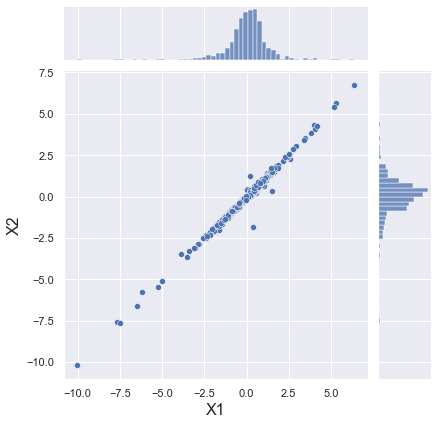

train:
DatetimeIndex(['2020-03-04', '2020-03-05', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-15',
               '2020-03-16', '2020-03-17',
               ...
               '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
               '2022-02-20', '2022-02-21', '2022-02-22', '2022-02-23',
               '2022-02-24', '2022-02-27'],
              dtype='datetime64[ns]', length=504, freq=None)
test:
DatetimeIndex(['2022-02-28', '2022-03-01', '2022-03-02', '2022-03-03',
               '2022-03-06', '2022-03-07', '2022-03-08', '2022-03-09',
               '2022-03-10', '2022-03-13',
               ...
               '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-19',
               '2023-02-20', '2023-02-21', '2023-02-22', '2023-02-23',
               '2023-02-26', '2023-02-27'],
              dtype='datetime64[ns]', length=252, freq=None)


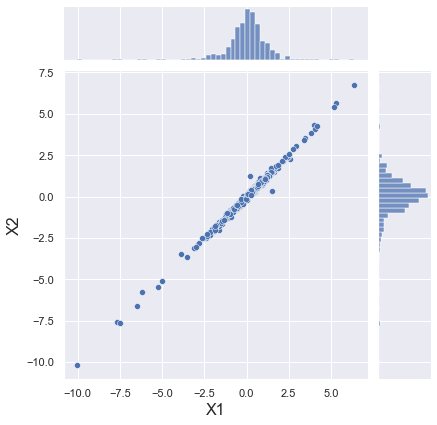

weight of ^AORD: 1
weight of ^AXJO: 1
long spread position:
^AORD: 100
^AXJO: -100
long spread value:
0


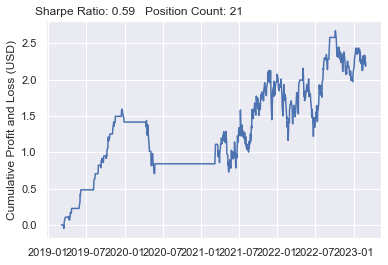

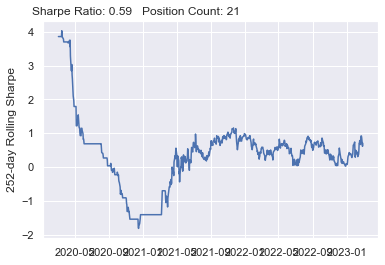

train:
DatetimeIndex(['2017-03-05', '2017-03-06', '2017-03-07', '2017-03-08',
               '2017-03-09', '2017-03-12', '2017-03-13', '2017-03-14',
               '2017-03-15', '2017-03-16',
               ...
               '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-24',
               '2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28',
               '2019-03-03', '2019-03-04'],
              dtype='datetime64[ns]', length=504, freq=None)
test:
DatetimeIndex(['2019-03-05', '2019-03-06', '2019-03-07', '2019-03-10',
               '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14',
               '2019-03-17', '2019-03-18',
               ...
               '2020-02-19', '2020-02-20', '2020-02-23', '2020-02-24',
               '2020-02-25', '2020-02-26', '2020-02-27', '2020-03-01',
               '2020-03-02', '2020-03-03'],
              dtype='datetime64[ns]', length=252, freq=None)
train:
DatetimeIndex(['2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08',
       

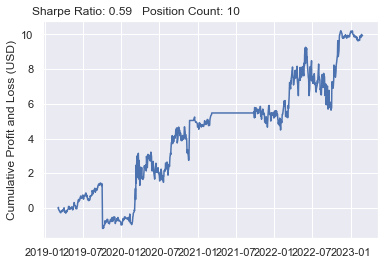

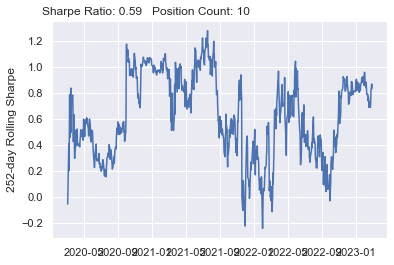

In [71]:
#main program
pair_distance = ['^AORD','^AXJO']
pair_svr = ['^BFX', '^FCHI']
pair_johansen = ['^FTSE','^RUT']

pair = pair_distance
rawdata = LoadData(pair_distance,period='7y')
rawdata.to_pickle('AORD_AXJO.pkl')
 
logreturn = CleanData(rawdata)
logreturn_cut = logreturn.iloc[75:,:]
price = CleanPriceData(rawdata)
logprice = np.log(price)
logprice = logprice.iloc[75:,:]
fdata = GARCHfilter(logreturn, window = 75)

copula_GARCH = Copula(pair, resetflag = True, formation_period = 504, trading_period = 252, outerbound = 0.3, innerbound = 0)
copula_GARCH.quickRun(fdata,logreturn,rolling = True)
mixedcopula_GARCH = Copula(pair, resetflag = True, formation_period = 504, trading_period = 252, outerbound = 0.3, innerbound = 0)
mixedcopula_GARCH.quickRun(fdata,logreturn,rolling = True)
copula = Copula(pair, resetflag = True, formation_period = 504, trading_period = 252, outerbound = 0.3, innerbound = 0)
copula.quickRun(logreturn_cut,logreturn,rolling = True)
mixedcopula = Copula(pair, resetflag = True, formation_period = 504, trading_period = 252, outerbound = 0.3, innerbound = 0)
mixedcopula.quickRun(logreturn_cut,logreturn,rolling = True)
cointegration = Cointegration(pair, threshold_option = 'rolling', formation_period = 504, trading_period = 252, outerbound = 0.3, innerbound = -0.3)
cointegration.quickRun(logprice,logreturn,rolling = True)

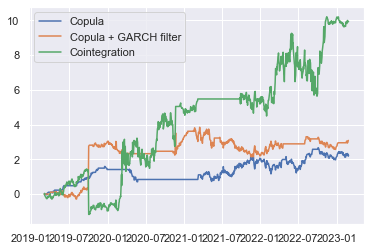

In [72]:
#plt.plot(copula.portfolio['PnL'])
#plt.plot(copula_GARCH.portfolio['PnL'])
plt.plot(mixedcopula.portfolio['PnL'])
plt.plot(mixedcopula_GARCH.portfolio['PnL'])
plt.plot(cointegration.portfolio['PnL'])
plt.legend(['Copula','Copula + GARCH filter','Cointegration'])
plt.show()

In [73]:
copula.signal

,^AORD,^AXJO
2019-03-05,0.547812,0.547812
2019-03-06,0.553875,0.447288
2019-03-07,0.429874,0.387774
2019-03-10,0.494608,0.494608
2019-03-11,0.630379,0.369301
...,...,...
2023-02-21,0.410919,0.587004
2023-02-22,0.578201,0.419353
2023-02-23,0.455851,0.544427
2023-02-26,0.40841,0.504657


In [74]:
copula.type

statsmodels.distributions.copula.archimedean.FrankCopula

In [75]:
print('Annualized Sharpe Ratio:')
print('Copula: ',np.sqrt(252)*copula.portfolio['Daily PnL'].mean()/copula.portfolio['Daily PnL'].std())
print('Copula+GARCH filter: ',np.sqrt(252)*copula_GARCH.portfolio['Daily PnL'].mean()/copula_GARCH.portfolio['Daily PnL'].std())
#print('Mixed Copula: ',np.sqrt(252)*mixedcopula.portfolio['Daily PnL'].mean()/mixedcopula.portfolio['Daily PnL'].std())
#print('Mixed Copula+GARCH filter: ',np.sqrt(252)*mixedcopula_GARCH.portfolio['Daily PnL'].mean()/mixedcopula_GARCH.portfolio['Daily PnL'].std())
print('Cointegration: ',np.sqrt(252)*cointegration.portfolio['Daily PnL'].mean()/cointegration.portfolio['Daily PnL'].std())
print('Position Counts: ')
print('Copula: ',copula.position_count)
print('Copula+GARCH filter: ',copula_GARCH.position_count)
#print('Mixed Copula: ',mixedcopula.position_count)
#print('Mixed Copula+GARCH filter: ',mixedcopula_GARCH.position_count)
print('Cointegration: ',cointegration.position_count)

Annualized Sharpe Ratio:
Copula:  0.5891805790369806
Copula+GARCH filter:  0.4145771710424504
Cointegration:  0.5864915252851512
Position Counts: 
Copula:  21
Copula+GARCH filter:  14
Cointegration:  10
